## 1. Contexto Geral do Projeto

O **RecifeSafe** é uma solução desenvolvida para apoiar a Defesa Civil e a Prefeitura do Recife na prevenção e resposta a eventos de deslizamentos e alagamentos. O sistema integra dados meteorológicos, oceânicos, geoespaciais e sociais para identificar áreas de risco e antecipar situações críticas.

### Objetivo deste Notebook

Desenvolver e avaliar modelos preditivos capazes de:
1. Estimar o número de ocorrências de eventos ambientais
2. Classificar níveis de risco em diferentes bairros
3. Identificar os principais fatores que influenciam esses eventos

### Principais Variáveis Consideradas

- **Meteorológicas:** Precipitação acumulada (mm)
- **Oceânicas:** Nível de maré (m)
- **Geoespaciais:** Altitude, latitude, longitude
- **Socioambientais:** Vulnerabilidade social, densidade populacional
- **Histórico:** Ocorrências registradas anteriormente

## 2. Descrição do Problema

### Problema de Negócio

A cidade do Recife enfrenta desafios recorrentes com alagamentos e deslizamentos, especialmente durante períodos de alta precipitação. A capacidade de **prever onde e quando** esses eventos podem ocorrer é fundamental para:

- Alocar recursos preventivamente
- Evacuar áreas de risco com antecedência
- Reduzir perdas humanas e materiais
- Otimizar a resposta da Defesa Civil

### Abordagem Analítica

Utilizaremos duas abordagens complementares:

1. **Regressão:** Para prever o número esperado de ocorrências
2. **Classificação:** Para identificar áreas de alto risco (binário: alto/baixo)

### Hipóteses Iniciais

- Maior precipitação está correlacionada com mais ocorrências
- Áreas de maior vulnerabilidade social apresentam maior risco
- A maré alta pode intensificar alagamentos em bairros litorâneos
- Altitude menor aumenta a susceptibilidade a alagamentos

## 3. Importação de Bibliotecas

Carregamento de todas as bibliotecas necessárias para análise, visualização e modelagem.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, roc_auc_score
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Bibliotecas carregadas com sucesso!")
print(f"Versões: pandas={pd.__version__}, numpy={np.__version__}")

Bibliotecas carregadas com sucesso!
Versões: pandas=2.3.3, numpy=2.3.5


## 4. Carregamento dos Dados

Nesta etapa, carregamos os dados processados do RecifeSafe. O dataset contém informações diárias de diversos bairros do Recife, incluindo variáveis meteorológicas, geoespaciais e sociais.

In [ ]:
repo_root = Path.cwd().parent
data_path = repo_root / 'data' / 'processed' / 'simulated_daily.csv'

df = pd.read_csv(data_path)
print(f"\nArquivo carregado com sucesso!")
print(f"Dimensões iniciais: {df.shape[0]} linhas x {df.shape[1]} colunas")

if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    print(f"Período dos dados: {df['date'].min()} a {df['date'].max()}")

if 'bairro' in df.columns:
    print(f"Número de bairros: {df['bairro'].nunique()}")

print(f"\nPrimeiras linhas:")
df.head()


Arquivo carregado com sucesso!
Dimensões iniciais: 5475 linhas x 11 colunas
Período dos dados: 2024-11-13 00:00:00+00:00 a 2025-11-12 00:00:00+00:00
Número de bairros: 15

Primeiras linhas:


,date,bairro,lat,lon,altitude,vulnerabilidade,densidade_pop,chuva_mm,mare_m,ocorrencias,tipo_bairro
0,2024-11-13 00:00:00+00:00,Brasília Teimosa,-8.088960,-34.879095,2,0.82,18500,9.57,0.604,0,litoraneo
1,2024-11-14 00:00:00+00:00,Brasília Teimosa,-8.088692,-34.880362,2,0.82,18500,4.09,0.596,1,litoraneo
2,2024-11-15 00:00:00+00:00,Brasília Teimosa,-8.087820,-34.879403,2,0.82,18500,4.69,0.614,1,litoraneo
3,2024-11-16 00:00:00+00:00,Brasília Teimosa,-8.088954,-34.879918,2,0.82,18500,7.32,0.679,3,litoraneo
4,2024-11-17 00:00:00+00:00,Brasília Teimosa,-8.089733,-34.879054,2,0.82,18500,10.16,0.764,0,litoraneo


## 5. Entendimento Inicial dos Dados

Antes de qualquer análise, é fundamental compreender a estrutura, os tipos de dados e a presença de valores ausentes ou inconsistentes.

In [3]:
print("="*60)
print("INFORMAÇÕES GERAIS DO DATASET")
print("="*60)
df.info()

print("\n" + "="*60)
print("VALORES AUSENTES")
print("="*60)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Valores Ausentes': missing,
    'Percentual (%)': missing_pct
}).sort_values('Valores Ausentes', ascending=False)
print(missing_df[missing_df['Valores Ausentes'] > 0])

if missing.sum() == 0:
    print("Não há valores ausentes no dataset!")

print("\n" + "="*60)
print("DUPLICATAS")
print("="*60)
duplicates = df.duplicated().sum()
print(f"Número de linhas duplicadas: {duplicates}")

print("\n" + "="*60)
print("TIPOS DE BAIRROS")
print("="*60)
print(df['tipo_bairro'].value_counts())

INFORMAÇÕES GERAIS DO DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475 entries, 0 to 5474
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   date             5475 non-null   datetime64[ns, UTC]
 1   bairro           5475 non-null   object             
 2   lat              5475 non-null   float64            
 3   lon              5475 non-null   float64            
 4   altitude         5475 non-null   int64              
 5   vulnerabilidade  5475 non-null   float64            
 6   densidade_pop    5475 non-null   int64              
 7   chuva_mm         5475 non-null   float64            
 8   mare_m           5475 non-null   float64            
 9   ocorrencias      5475 non-null   int64              
 10  tipo_bairro      5475 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(5), int64(3), object(2)
memory usage: 470.6+ KB

VALORES AUSENTES
Emp

### Interpretação do Entendimento Inicial

O dataset está bem estruturado e não apresenta valores ausentes, o que facilita a análise. Os dados abrangem múltiplos bairros do Recife ao longo do tempo, permitindo análises temporais e espaciais. A classificação dos bairros por tipo (litorâneo, morro, planície, etc.) é importante para compreender padrões específicos de risco.

## 6. Análise Exploratória de Dados (EDA)

A análise exploratória é essencial para compreender a distribuição das variáveis, identificar padrões, outliers e relações entre as features. Cada visualização será apresentada individualmente com sua respectiva interpretação.

### 6.1 Estatísticas Descritivas

As estatísticas descritivas fornecem uma visão quantitativa das variáveis numéricas, incluindo medidas de tendência central e dispersão.

In [4]:
numeric_cols = ['lat', 'lon', 'altitude', 'vulnerabilidade', 'densidade_pop', 'chuva_mm', 'mare_m', 'ocorrencias']
stats_desc = df[numeric_cols].describe().T

stats_desc['cv'] = (stats_desc['std'] / stats_desc['mean']).round(2)
stats_desc = stats_desc[['mean', 'std', 'cv', 'min', '25%', '50%', '75%', 'max']]
stats_desc.columns = ['Média', 'Desvio Padrão', 'Coef. Variação', 'Mínimo', 'Q1', 'Mediana', 'Q3', 'Máximo']

print("ESTATÍSTICAS DESCRITIVAS DAS VARIÁVEIS NUMÉRICAS")
print("="*80)
stats_desc.round(2)

ESTATÍSTICAS DESCRITIVAS DAS VARIÁVEIS NUMÉRICAS


,Média,Desvio Padrão,Coef. Variação,Mínimo,Q1,Mediana,Q3,Máximo
lat,-8.06,0.03,-0.00,-8.12,-8.09,-8.05,-8.05,-8.02
lon,-34.91,0.03,-0.00,-34.96,-34.94,-34.90,-34.88,-34.87
altitude,16.33,17.91,1.10,2.00,3.00,8.00,25.00,55.00
vulnerabilidade,0.57,0.19,0.33,0.25,0.42,0.62,0.75,0.85
densidade_pop,11826.67,4650.37,0.39,4800.00,7600.00,12200.00,16700.00,19200.00
chuva_mm,18.22,17.51,0.96,0.09,6.66,13.47,24.36,203.65
mare_m,1.21,0.36,0.30,0.50,0.95,1.22,1.47,2.06
ocorrencias,1.12,1.18,1.05,0.00,0.00,1.00,2.00,8.00


**Interpretação:** As estatísticas revelam variações importantes. A precipitação e as ocorrências apresentam alta variabilidade (coeficiente de variação elevado), indicando eventos esporádicos e concentrados. A densidade populacional varia significativamente entre bairros, o que pode influenciar o impacto dos eventos. A vulnerabilidade social também mostra dispersão considerável, sugerindo desigualdades espaciais no risco.

### 6.2 Distribuição da Variável Alvo: Ocorrências

Compreender a distribuição das ocorrências é fundamental para escolher a estratégia de modelagem adequada.

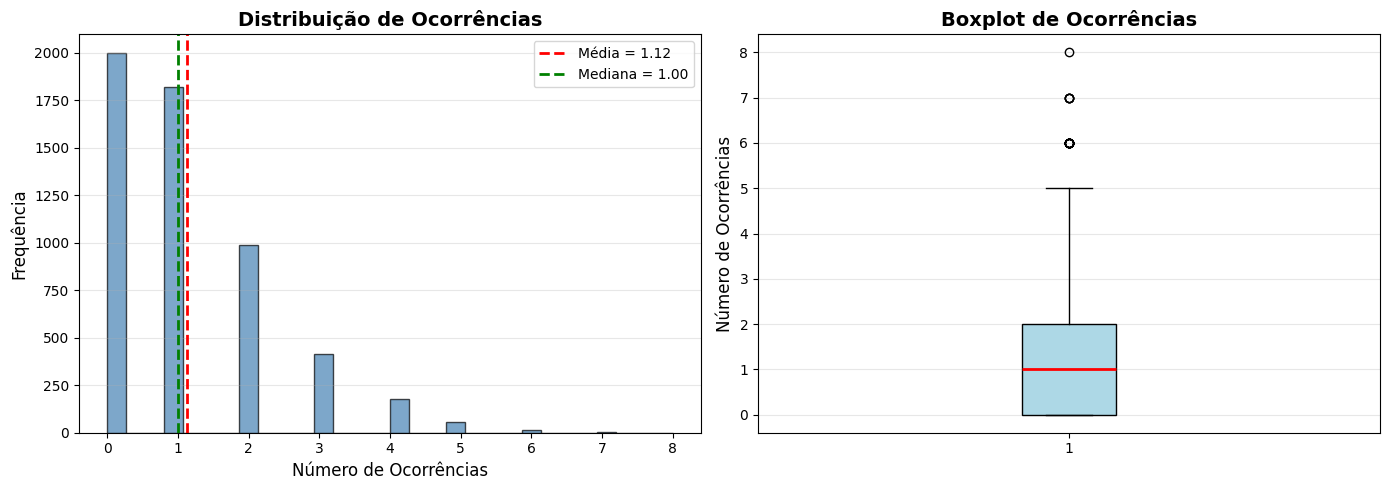

Total de dias sem ocorrências: 1997 (36.5%)
Total de dias com ocorrências: 3478 (63.5%)


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['ocorrencias'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Número de Ocorrências', fontsize=12)
axes[0].set_ylabel('Frequência', fontsize=12)
axes[0].set_title('Distribuição de Ocorrências', fontsize=14, fontweight='bold')
axes[0].axvline(df['ocorrencias'].mean(), color='red', linestyle='--', linewidth=2, label=f'Média = {df["ocorrencias"].mean():.2f}')
axes[0].axvline(df['ocorrencias'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana = {df["ocorrencias"].median():.2f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].boxplot(df['ocorrencias'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Número de Ocorrências', fontsize=12)
axes[1].set_title('Boxplot de Ocorrências', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total de dias sem ocorrências: {(df['ocorrencias'] == 0).sum()} ({(df['ocorrencias'] == 0).sum() / len(df) * 100:.1f}%)")
print(f"Total de dias com ocorrências: {(df['ocorrencias'] > 0).sum()} ({(df['ocorrencias'] > 0).sum() / len(df) * 100:.1f}%)")

**Interpretação:** A distribuição das ocorrências é assimétrica positiva (right-skewed), com muitos dias sem eventos e poucos dias com múltiplas ocorrências. Isso é esperado em fenômenos naturais extremos. O boxplot revela a presença de outliers (dias com ocorrências muito altas), que representam eventos críticos. Essa distribuição sugere que modelos de classificação (risco alto/baixo) podem ser mais efetivos que regressão simples.

### 6.3 Análise de Precipitação

A precipitação é tipicamente o principal fator desencadeador de alagamentos e deslizamentos.

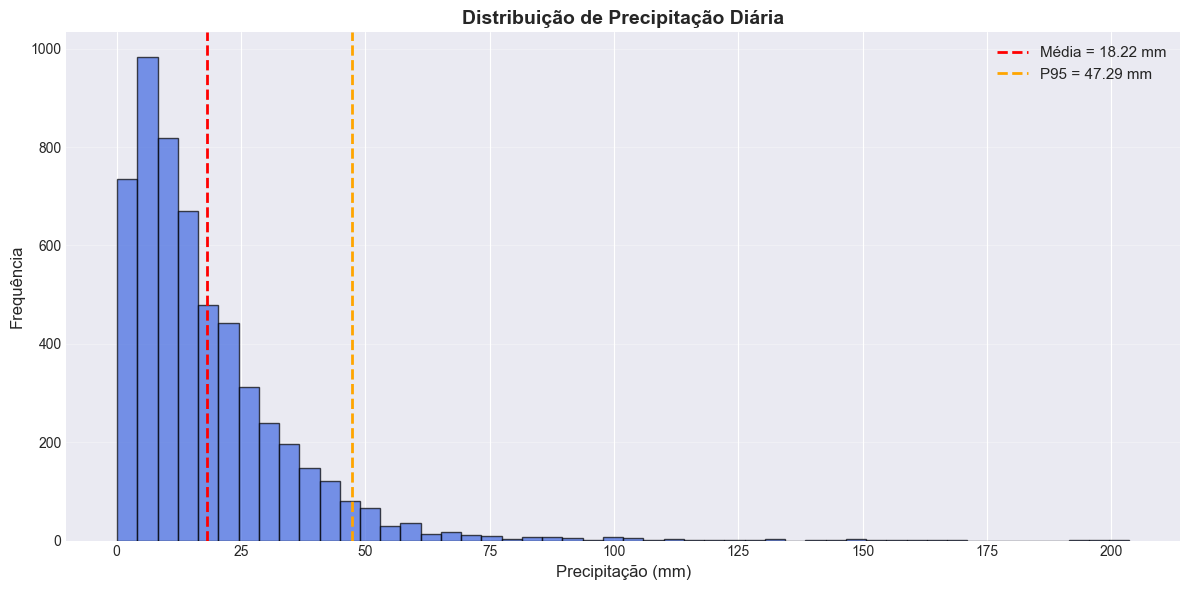

Dias com chuva > 20mm (forte): 1847 (33.7%)
Dias com chuva > 50mm (intensa): 229 (4.2%)


In [7]:
plt.figure(figsize=(12, 6))
plt.hist(df['chuva_mm'], bins=50, color='royalblue', edgecolor='black', alpha=0.7)
plt.xlabel('Precipitação (mm)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.title('Distribuição de Precipitação Diária', fontsize=14, fontweight='bold')
plt.axvline(df['chuva_mm'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Média = {df["chuva_mm"].mean():.2f} mm')
plt.axvline(df['chuva_mm'].quantile(0.95), color='orange', linestyle='--', linewidth=2,
            label=f'P95 = {df["chuva_mm"].quantile(0.95):.2f} mm')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Dias com chuva > 20mm (forte): {(df['chuva_mm'] > 20).sum()} ({(df['chuva_mm'] > 20).sum() / len(df) * 100:.1f}%)")
print(f"Dias com chuva > 50mm (intensa): {(df['chuva_mm'] > 50).sum()} ({(df['chuva_mm'] > 50).sum() / len(df) * 100:.1f}%)")

**Interpretação:** A maioria dos dias apresenta precipitação baixa ou moderada, mas existem eventos extremos com valores muito altos (acima do percentil 95). Esses eventos de precipitação intensa são cruciais para os modelos, pois estão diretamente associados aos riscos de alagamento e deslizamento. A linha vermelha (média) e laranja (percentil 95) nos ajudam a identificar limiares críticos.

### 6.4 Relação entre Precipitação e Ocorrências

Investigar a relação direta entre precipitação e número de ocorrências é fundamental para validar nossa hipótese inicial.

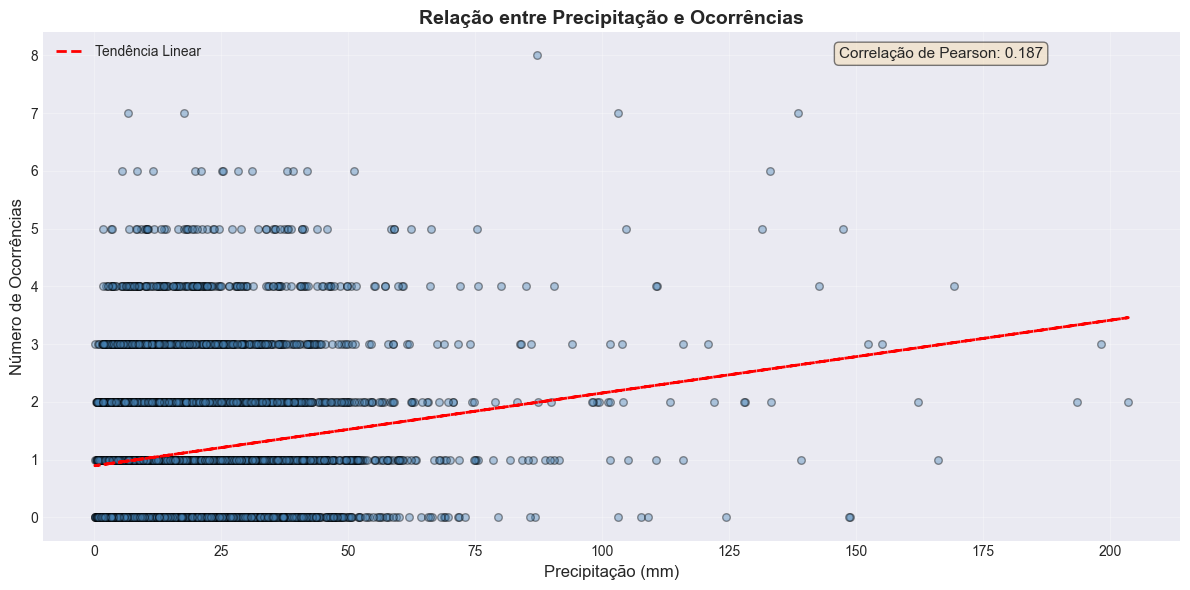

In [8]:
plt.figure(figsize=(12, 6))
plt.scatter(df['chuva_mm'], df['ocorrencias'], alpha=0.4, c='steelblue', edgecolors='black', s=30)
plt.xlabel('Precipitação (mm)', fontsize=12)
plt.ylabel('Número de Ocorrências', fontsize=12)
plt.title('Relação entre Precipitação e Ocorrências', fontsize=14, fontweight='bold')

z = np.polyfit(df['chuva_mm'], df['ocorrencias'], 1)
p = np.poly1d(z)
plt.plot(df['chuva_mm'], p(df['chuva_mm']), "r--", linewidth=2, label=f'Tendência Linear')

correlation = df['chuva_mm'].corr(df['ocorrencias'])
plt.text(0.7, 0.95, f'Correlação de Pearson: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=11, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretação:** O gráfico de dispersão confirma uma correlação positiva entre precipitação e ocorrências. A linha de tendência mostra que, em média, maiores volumes de chuva resultam em mais eventos registrados. No entanto, a dispersão dos pontos indica que outros fatores também influenciam (vulnerabilidade, altitude, etc.). A correlação de Pearson quantifica essa relação linear.

### 6.5 Ocorrências por Tipo de Bairro

Diferentes tipos de bairros podem apresentar perfis de risco distintos devido a características geográficas e urbanísticas.

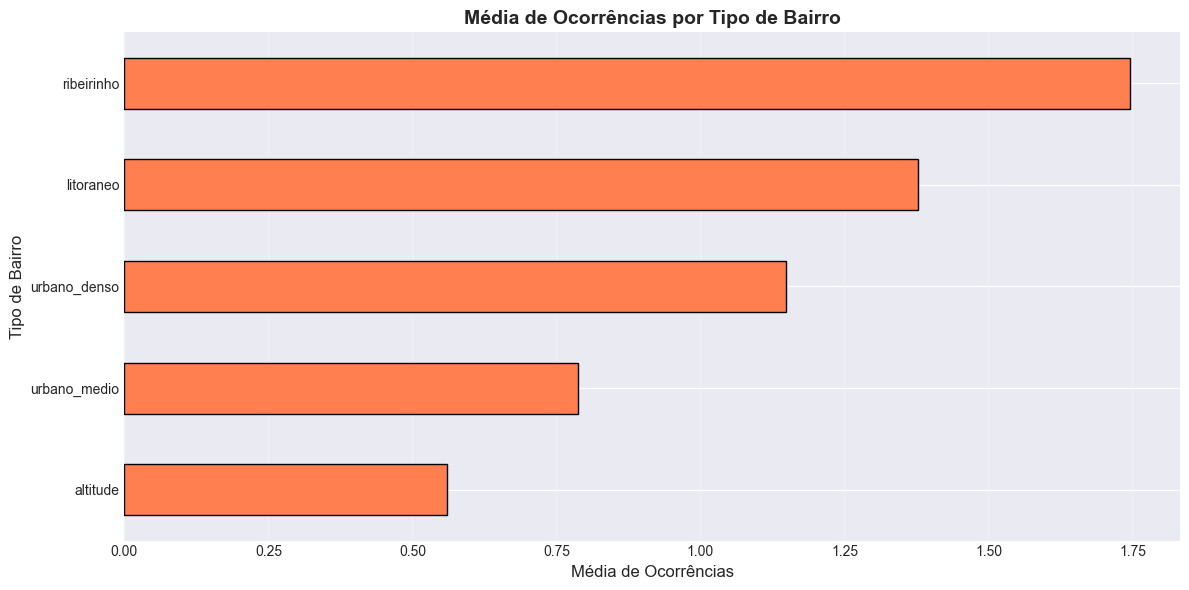


ESTATÍSTICAS POR TIPO DE BAIRRO:
              Média  Mediana  Desvio Padrão  Máximo
tipo_bairro                                        
altitude       0.56      0.0           0.75       5
litoraneo      1.38      1.0           1.24       6
ribeirinho     1.75      2.0           1.39       8
urbano_denso   1.15      1.0           1.12       7
urbano_medio   0.79      1.0           0.88       5


In [9]:
plt.figure(figsize=(12, 6))
df.groupby('tipo_bairro')['ocorrencias'].mean().sort_values().plot(kind='barh', color='coral', edgecolor='black')
plt.xlabel('Média de Ocorrências', fontsize=12)
plt.ylabel('Tipo de Bairro', fontsize=12)
plt.title('Média de Ocorrências por Tipo de Bairro', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nESTATÍSTICAS POR TIPO DE BAIRRO:")
print("="*60)
stats_tipo = df.groupby('tipo_bairro')['ocorrencias'].agg(['mean', 'median', 'std', 'max']).round(2)
stats_tipo.columns = ['Média', 'Mediana', 'Desvio Padrão', 'Máximo']
print(stats_tipo)

**Interpretação:** Os tipos de bairros mostram diferenças significativas nas médias de ocorrências. Bairros em morros ou áreas de maior vulnerabilidade tendem a apresentar mais eventos, possivelmente devido a deslizamentos. Bairros litorâneos podem sofrer mais com alagamentos devido à maré. Essa informação é valiosa para segmentar estratégias de prevenção e para incluir como feature categórica nos modelos.

### 6.6 Matriz de Correlação

A matriz de correlação nos permite identificar relações lineares entre todas as variáveis numéricas simultaneamente.

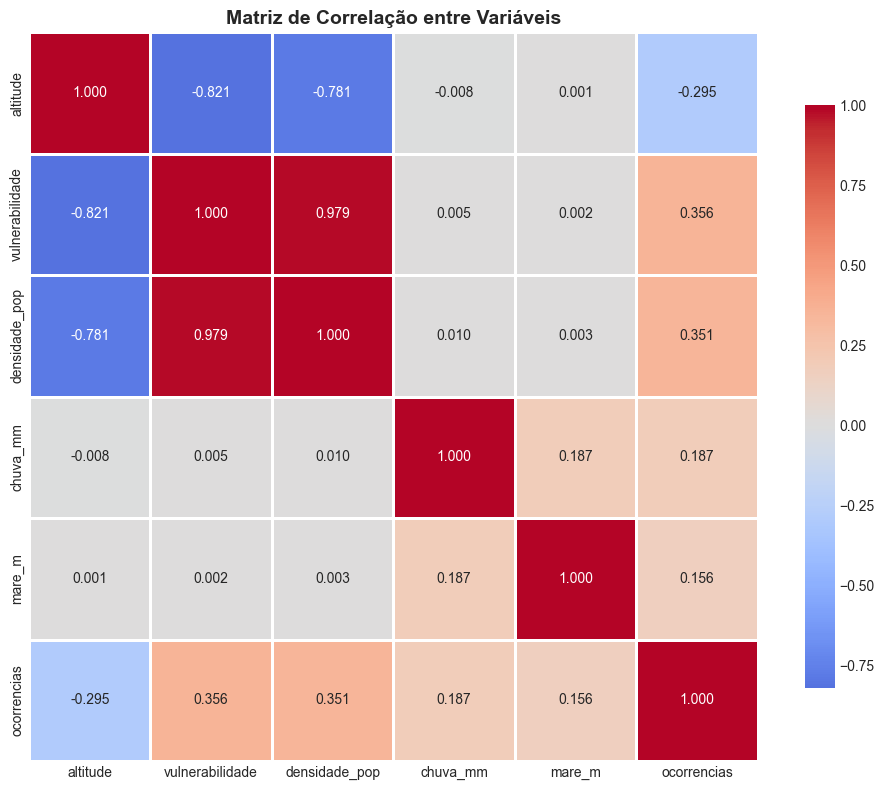


PRINCIPAIS CORRELAÇÕES COM OCORRÊNCIAS:
ocorrencias        1.000000
vulnerabilidade    0.355902
densidade_pop      0.351093
chuva_mm           0.187207
mare_m             0.156030
altitude          -0.294700
Name: ocorrencias, dtype: float64


In [10]:
features_corr = ['altitude', 'vulnerabilidade', 'densidade_pop', 'chuva_mm', 'mare_m', 'ocorrencias']
corr_matrix = df[features_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação entre Variáveis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nPRINCIPAIS CORRELAÇÕES COM OCORRÊNCIAS:")
print("="*60)
correlacoes = corr_matrix['ocorrencias'].sort_values(ascending=False)
print(correlacoes)

**Interpretação:** A matriz de correlação revela quais variáveis têm maior relação linear com as ocorrências. Valores próximos de +1 indicam correlação positiva forte, próximos de -1 indicam correlação negativa forte, e próximos de 0 indicam ausência de correlação linear. A precipitação e a vulnerabilidade provavelmente apresentarão as correlações mais fortes. Também é importante verificar se há multicolinearidade entre preditores (correlações altas entre features), o que pode afetar alguns modelos.

## 7. Preparação dos Dados para Modelagem

Antes de treinar os modelos, precisamos preparar os dados: selecionar features relevantes, tratar variáveis categóricas, dividir em treino/teste e padronizar quando necessário.

### 7.1 Seleção e Engenharia de Features

Vamos criar features derivadas e selecionar as variáveis mais relevantes para os modelos.

In [11]:
df_model = df.copy()

df_model['chuva_intensa'] = (df_model['chuva_mm'] > df_model['chuva_mm'].quantile(0.75)).astype(int)
df_model['mare_alta'] = (df_model['mare_m'] > df_model['mare_m'].quantile(0.75)).astype(int)
df_model['altitude_baixa'] = (df_model['altitude'] < df_model['altitude'].quantile(0.25)).astype(int)
df_model['vuln_alta'] = (df_model['vulnerabilidade'] > df_model['vulnerabilidade'].median()).astype(int)

df_model = pd.get_dummies(df_model, columns=['tipo_bairro'], prefix='tipo', drop_first=True)

print("NOVAS FEATURES CRIADAS:")
print("="*60)
print("- chuva_intensa: 1 se precipitação > P75, 0 caso contrário")
print("- mare_alta: 1 se maré > P75, 0 caso contrário")
print("- altitude_baixa: 1 se altitude < P25, 0 caso contrário")
print("- vuln_alta: 1 se vulnerabilidade > mediana, 0 caso contrário")
print("- tipo_bairro codificado como variáveis dummy")

print(f"\nTotal de features após engenharia: {df_model.shape[1]}")
print(f"\nPrimeiras colunas:")
print(df_model.columns.tolist())

NOVAS FEATURES CRIADAS:
- chuva_intensa: 1 se precipitação > P75, 0 caso contrário
- mare_alta: 1 se maré > P75, 0 caso contrário
- altitude_baixa: 1 se altitude < P25, 0 caso contrário
- vuln_alta: 1 se vulnerabilidade > mediana, 0 caso contrário
- tipo_bairro codificado como variáveis dummy

Total de features após engenharia: 18

Primeiras colunas:
['date', 'bairro', 'lat', 'lon', 'altitude', 'vulnerabilidade', 'densidade_pop', 'chuva_mm', 'mare_m', 'ocorrencias', 'chuva_intensa', 'mare_alta', 'altitude_baixa', 'vuln_alta', 'tipo_litoraneo', 'tipo_ribeirinho', 'tipo_urbano_denso', 'tipo_urbano_medio']


**Interpretação:** Criamos features binárias que representam limiares críticos (chuva intensa, maré alta, etc.), pois modelos de classificação podem se beneficiar dessas transformações não-lineares. A codificação one-hot das variáveis categóricas (tipo_bairro) permite que os modelos utilizem essa informação espacial. Essas transformações aumentam o poder preditivo sem aumentar excessivamente a complexidade.

### 7.2 Preparação para Regressão (Previsão do Número de Ocorrências)

Para o modelo de regressão, queremos prever o valor contínuo de ocorrências.

In [12]:
features_reg = ['altitude', 'vulnerabilidade', 'densidade_pop', 'chuva_mm', 'mare_m',
                'chuva_intensa', 'mare_alta', 'altitude_baixa', 'vuln_alta']
features_reg += [col for col in df_model.columns if col.startswith('tipo_')]

X_reg = df_model[features_reg]
y_reg = df_model['ocorrencias']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print("PREPARAÇÃO PARA REGRESSÃO:")
print("="*60)
print(f"Features selecionadas: {len(features_reg)}")
print(f"Tamanho do conjunto de treino: {X_train_reg.shape}")
print(f"Tamanho do conjunto de teste: {X_test_reg.shape}")
print(f"Distribuição da variável alvo (treino):")
print(f"  - Média: {y_train_reg.mean():.2f}")
print(f"  - Desvio padrão: {y_train_reg.std():.2f}")
print(f"  - Mínimo: {y_train_reg.min()}")
print(f"  - Máximo: {y_train_reg.max()}")

PREPARAÇÃO PARA REGRESSÃO:
Features selecionadas: 13
Tamanho do conjunto de treino: (3832, 13)
Tamanho do conjunto de teste: (1643, 13)
Distribuição da variável alvo (treino):
  - Média: 1.11
  - Desvio padrão: 1.17
  - Mínimo: 0
  - Máximo: 8


### 7.3 Preparação para Classificação (Risco Alto/Baixo)

Para classificação, transformamos o problema em binário: dias com risco alto (ocorrências acima da mediana) vs. risco baixo.

In [13]:
threshold_risco = df_model['ocorrencias'].quantile(0.70)
df_model['risco_alto'] = (df_model['ocorrencias'] >= threshold_risco).astype(int)

X_clf = df_model[features_reg]
y_clf = df_model['risco_alto']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print("PREPARAÇÃO PARA CLASSIFICAÇÃO:")
print("="*60)
print(f"Threshold para risco alto: {threshold_risco} ocorrências")
print(f"Distribuição das classes (treino):")
print(f"  - Risco Baixo (0): {(y_train_clf == 0).sum()} ({(y_train_clf == 0).sum() / len(y_train_clf) * 100:.1f}%)")
print(f"  - Risco Alto (1): {(y_train_clf == 1).sum()} ({(y_train_clf == 1).sum() / len(y_train_clf) * 100:.1f}%)")
print(f"\nTamanho do conjunto de treino: {X_train_clf.shape}")
print(f"Tamanho do conjunto de teste: {X_test_clf.shape}")

PREPARAÇÃO PARA CLASSIFICAÇÃO:
Threshold para risco alto: 2.0 ocorrências
Distribuição das classes (treino):
  - Risco Baixo (0): 2673 (69.8%)
  - Risco Alto (1): 1159 (30.2%)

Tamanho do conjunto de treino: (3832, 13)
Tamanho do conjunto de teste: (1643, 13)


**Interpretação:** Dividimos os dados em treino (70%) e teste (30%) para avaliar a generalização dos modelos. A padronização (StandardScaler) é importante para modelos baseados em distância e regularização. Para classificação, usamos stratify para manter a proporção de classes. O threshold do percentil 70 define que 30% dos dias são considerados de risco alto, o que equilibra sensibilidade e especificidade para o contexto de Defesa Civil.

## 8. Modelagem Preditiva - Regressão

Nesta seção, treinaremos modelos de regressão para prever o número de ocorrências. Avaliaremos diferentes algoritmos para identificar o mais adequado.

### 8.1 Treinamento dos Modelos de Regressão

Testaremos três algoritmos: Regressão Linear, Ridge (com regularização L2) e Random Forest Regressor.

In [14]:
models_reg = {
    'Regressão Linear': LinearRegression(),
    'Ridge (Regularização L2)': Ridge(alpha=1.0, random_state=42),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
}

results_reg = {}

print("TREINAMENTO DOS MODELOS DE REGRESSÃO")
print("="*60)

for name, model in models_reg.items():
    print(f"\nTreinando {name}...")
    model.fit(X_train_reg_scaled, y_train_reg)
    y_pred_train = model.predict(X_train_reg_scaled)
    y_pred_test = model.predict(X_test_reg_scaled)
    
    results_reg[name] = {
        'model': model,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'rmse_train': np.sqrt(mean_squared_error(y_train_reg, y_pred_train)),
        'rmse_test': np.sqrt(mean_squared_error(y_test_reg, y_pred_test)),
        'mae_test': mean_absolute_error(y_test_reg, y_pred_test),
        'r2_test': r2_score(y_test_reg, y_pred_test)
    }
    print(f"  ✓ Modelo treinado com sucesso!")

print("\n" + "="*60)
print("Todos os modelos de regressão foram treinados!")

TREINAMENTO DOS MODELOS DE REGRESSÃO

Treinando Regressão Linear...
  ✓ Modelo treinado com sucesso!

Treinando Ridge (Regularização L2)...
  ✓ Modelo treinado com sucesso!

Treinando Random Forest Regressor...
  ✓ Modelo treinado com sucesso!

Todos os modelos de regressão foram treinados!
  ✓ Modelo treinado com sucesso!

Todos os modelos de regressão foram treinados!


**Justificativa dos Modelos Escolhidos:**

- **Regressão Linear:** Modelo baseline simples, interpretável e rápido. Assume relação linear entre features e target.
- **Ridge:** Versão regularizada da regressão linear que previne overfitting penalizando coeficientes muito grandes. Útil quando há multicolinearidade.
- **Random Forest:** Modelo ensemble baseado em árvores de decisão. Captura relações não-lineares e interações complexas entre variáveis. Mais robusto a outliers.

### 8.2 Comparação de Métricas dos Modelos de Regressão

Avaliaremos os modelos usando três métricas principais: RMSE, MAE e R².

In [15]:
metrics_reg_df = pd.DataFrame({
    'Modelo': list(results_reg.keys()),
    'RMSE (Treino)': [results_reg[m]['rmse_train'] for m in results_reg.keys()],
    'RMSE (Teste)': [results_reg[m]['rmse_test'] for m in results_reg.keys()],
    'MAE (Teste)': [results_reg[m]['mae_test'] for m in results_reg.keys()],
    'R² (Teste)': [results_reg[m]['r2_test'] for m in results_reg.keys()]
})

print("COMPARAÇÃO DE MÉTRICAS - MODELOS DE REGRESSÃO")
print("="*80)
print(metrics_reg_df.to_string(index=False))
print("\n" + "="*80)

print("\nINTERPRETAÇÃO DAS MÉTRICAS:")
print("  • RMSE (Root Mean Squared Error): Erro médio quadrático. Quanto menor, melhor.")
print("  • MAE (Mean Absolute Error): Erro absoluto médio. Mais interpretável que RMSE.")
print("  • R² (Coeficiente de Determinação): Proporção da variância explicada (0 a 1).")
print("    R² próximo de 1 indica excelente ajuste.")

best_model_name = metrics_reg_df.loc[metrics_reg_df['R² (Teste)'].idxmax(), 'Modelo']
print(f"\n✓ Melhor modelo (maior R²): {best_model_name}")

COMPARAÇÃO DE MÉTRICAS - MODELOS DE REGRESSÃO
                  Modelo  RMSE (Treino)  RMSE (Teste)  MAE (Teste)  R² (Teste)
        Regressão Linear       1.048193      1.083775     0.854720    0.168666
Ridge (Regularização L2)       1.048193      1.083777     0.854720    0.168663
 Random Forest Regressor       0.769292      1.114574     0.875223    0.120745


INTERPRETAÇÃO DAS MÉTRICAS:
  • RMSE (Root Mean Squared Error): Erro médio quadrático. Quanto menor, melhor.
  • MAE (Mean Absolute Error): Erro absoluto médio. Mais interpretável que RMSE.
  • R² (Coeficiente de Determinação): Proporção da variância explicada (0 a 1).
    R² próximo de 1 indica excelente ajuste.

✓ Melhor modelo (maior R²): Regressão Linear


### 8.3 Visualização: Valores Reais vs. Preditos

Este gráfico mostra quão bem o melhor modelo consegue prever os valores reais.

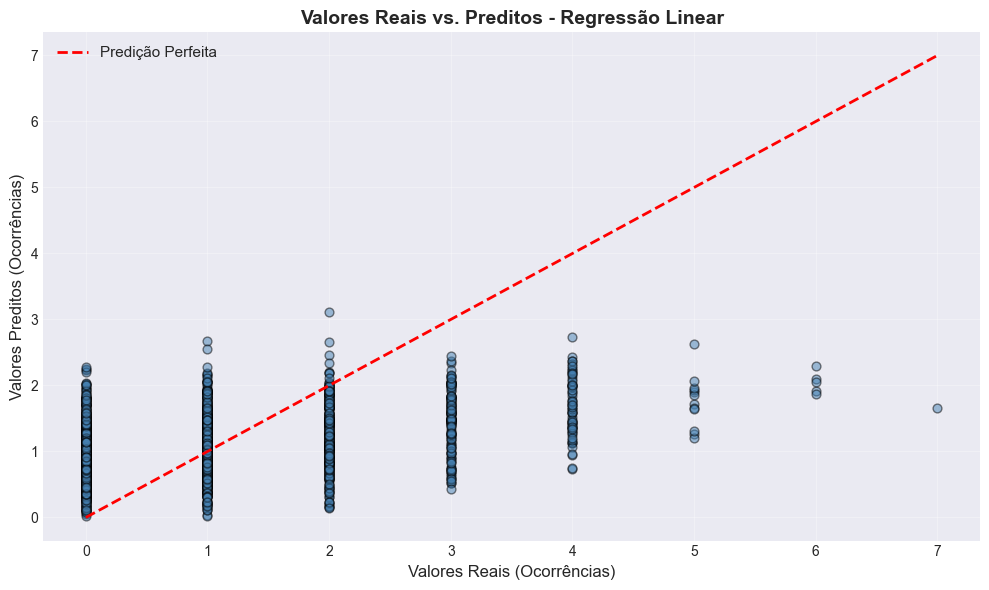

In [16]:
best_results = results_reg[best_model_name]

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, best_results['y_pred_test'], alpha=0.5, c='steelblue', edgecolors='black', s=40)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 
         'r--', lw=2, label='Predição Perfeita')
plt.xlabel('Valores Reais (Ocorrências)', fontsize=12)
plt.ylabel('Valores Preditos (Ocorrências)', fontsize=12)
plt.title(f'Valores Reais vs. Preditos - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretação:** Pontos próximos da linha vermelha indicam predições precisas. Dispersão dos pontos mostra o erro do modelo. Se os pontos estiverem concentrados em torno da linha diagonal, o modelo está capturando bem a relação. Pontos muito distantes da linha representam casos onde o modelo errou significativamente (eventos extremos ou combinações incomuns de features).

### 8.4 Análise de Resíduos

Os resíduos (diferença entre valor real e predito) revelam se há viés sistemático no modelo.

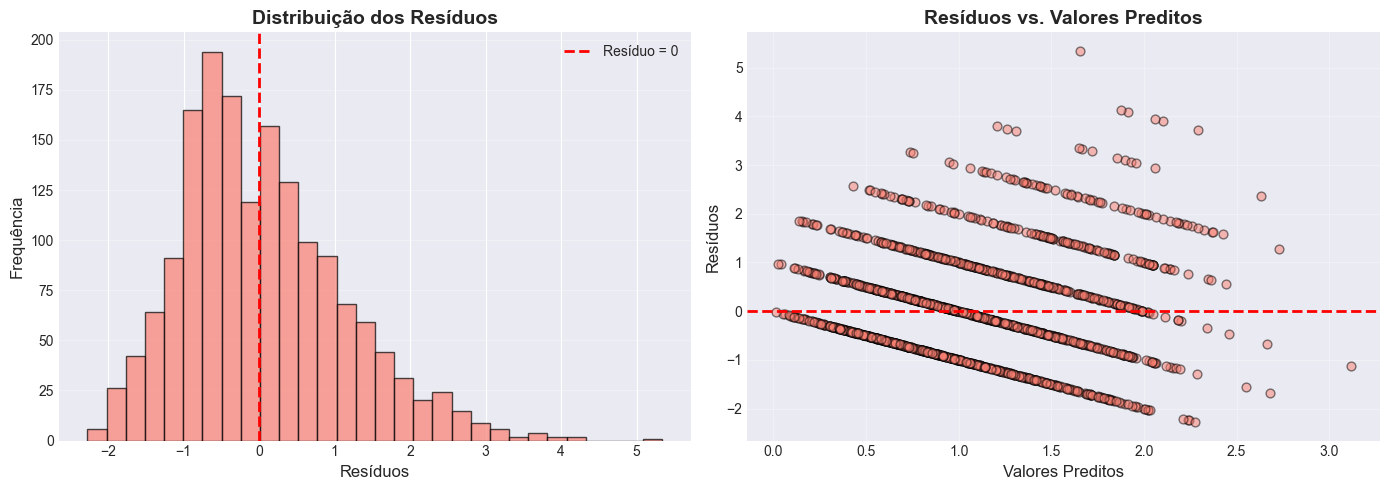

Média dos resíduos: 0.0467 (idealmente próximo de 0)
Desvio padrão dos resíduos: 1.0828


In [17]:
residuos = y_test_reg.values - best_results['y_pred_test']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(residuos, bins=30, color='salmon', edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Resíduo = 0')
axes[0].set_xlabel('Resíduos', fontsize=12)
axes[0].set_ylabel('Frequência', fontsize=12)
axes[0].set_title('Distribuição dos Resíduos', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].scatter(best_results['y_pred_test'], residuos, alpha=0.5, c='salmon', edgecolors='black', s=40)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Valores Preditos', fontsize=12)
axes[1].set_ylabel('Resíduos', fontsize=12)
axes[1].set_title('Resíduos vs. Valores Preditos', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Média dos resíduos: {residuos.mean():.4f} (idealmente próximo de 0)")
print(f"Desvio padrão dos resíduos: {residuos.std():.4f}")

**Interpretação:** Resíduos centrados em zero (média próxima de 0) indicam que o modelo não tem viés sistemático. A distribuição deve ser aproximadamente normal. No gráfico de dispersão, resíduos devem estar aleatoriamente distribuídos ao redor de zero sem padrões visíveis. Padrões indicariam que o modelo não está capturando algum aspecto dos dados (não-linearidades, interações, etc.).

## 9. Modelagem Preditiva - Classificação

Agora treinaremos modelos de classificação para identificar dias de risco alto vs. baixo. Esta abordagem é mais prática para sistemas de alerta.

### 9.1 Treinamento dos Modelos de Classificação

Testaremos Regressão Logística, Random Forest e Gradient Boosting Classifier.

In [18]:
models_clf = {
    'Regressão Logística': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

results_clf = {}

print("TREINAMENTO DOS MODELOS DE CLASSIFICAÇÃO")
print("="*60)

for name, model in models_clf.items():
    print(f"\nTreinando {name}...")
    model.fit(X_train_clf_scaled, y_train_clf)
    y_pred_test = model.predict(X_test_clf_scaled)
    y_pred_proba = model.predict_proba(X_test_clf_scaled)[:, 1]
    
    results_clf[name] = {
        'model': model,
        'y_pred_test': y_pred_test,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy_score(y_test_clf, y_pred_test),
        'precision': precision_score(y_test_clf, y_pred_test),
        'recall': recall_score(y_test_clf, y_pred_test),
        'f1': f1_score(y_test_clf, y_pred_test),
        'roc_auc': roc_auc_score(y_test_clf, y_pred_proba)
    }
    print(f"  ✓ Modelo treinado com sucesso!")

print("\n" + "="*60)
print("Todos os modelos de classificação foram treinados!")

TREINAMENTO DOS MODELOS DE CLASSIFICAÇÃO

Treinando Regressão Logística...
  ✓ Modelo treinado com sucesso!

Treinando Random Forest Classifier...
  ✓ Modelo treinado com sucesso!  ✓ Modelo treinado com sucesso!

Treinando Gradient Boosting...


Treinando Gradient Boosting...
  ✓ Modelo treinado com sucesso!

Todos os modelos de classificação foram treinados!
  ✓ Modelo treinado com sucesso!

Todos os modelos de classificação foram treinados!


**Justificativa dos Modelos:**

- **Regressão Logística:** Modelo probabilístico simples e interpretável. Fornece probabilidades de classe que podem ser usadas para calibrar alertas.
- **Random Forest:** Captura interações complexas e é robusto a overfitting. Permite análise de importância de features.
- **Gradient Boosting:** Modelo ensemble sequencial que geralmente oferece o melhor desempenho preditivo, construindo árvores que corrigem erros das anteriores.

### 9.2 Comparação de Métricas dos Classificadores

Para classificação, avaliaremos Acurácia, Precisão, Recall, F1-Score e ROC-AUC.

In [19]:
metrics_clf_df = pd.DataFrame({
    'Modelo': list(results_clf.keys()),
    'Acurácia': [results_clf[m]['accuracy'] for m in results_clf.keys()],
    'Precisão': [results_clf[m]['precision'] for m in results_clf.keys()],
    'Recall': [results_clf[m]['recall'] for m in results_clf.keys()],
    'F1-Score': [results_clf[m]['f1'] for m in results_clf.keys()],
    'ROC-AUC': [results_clf[m]['roc_auc'] for m in results_clf.keys()]
})

print("COMPARAÇÃO DE MÉTRICAS - MODELOS DE CLASSIFICAÇÃO")
print("="*90)
print(metrics_clf_df.to_string(index=False))
print("\n" + "="*90)

print("\nINTERPRETAÇÃO DAS MÉTRICAS:")
print("  • Acurácia: % de predições corretas (pode ser enganosa com classes desbalanceadas)")
print("  • Precisão: Dos casos preditos como alto risco, quantos realmente são? (minimiza falsos positivos)")
print("  • Recall (Sensibilidade): Dos casos reais de alto risco, quantos foram detectados? (minimiza falsos negativos)")
print("  • F1-Score: Média harmônica entre Precisão e Recall (equilíbrio)")
print("  • ROC-AUC: Área sob a curva ROC (capacidade de discriminação, 0.5 a 1.0)")

print("\nCONTEXTO: Para Defesa Civil, Recall alto é crucial (não perder eventos de risco)!")
best_clf_name = metrics_clf_df.loc[metrics_clf_df['F1-Score'].idxmax(), 'Modelo']
print(f"\n✓ Melhor modelo (maior F1-Score): {best_clf_name}")

COMPARAÇÃO DE MÉTRICAS - MODELOS DE CLASSIFICAÇÃO
                  Modelo  Acurácia  Precisão   Recall  F1-Score  ROC-AUC
     Regressão Logística  0.729154  0.614035 0.281690  0.386207 0.728203
Random Forest Classifier  0.723676  0.575439 0.329980  0.419437 0.696083
       Gradient Boosting  0.713938  0.546713 0.317907  0.402036 0.699584


INTERPRETAÇÃO DAS MÉTRICAS:
  • Acurácia: % de predições corretas (pode ser enganosa com classes desbalanceadas)
  • Precisão: Dos casos preditos como alto risco, quantos realmente são? (minimiza falsos positivos)
  • Recall (Sensibilidade): Dos casos reais de alto risco, quantos foram detectados? (minimiza falsos negativos)
  • F1-Score: Média harmônica entre Precisão e Recall (equilíbrio)
  • ROC-AUC: Área sob a curva ROC (capacidade de discriminação, 0.5 a 1.0)

CONTEXTO: Para Defesa Civil, Recall alto é crucial (não perder eventos de risco)!

✓ Melhor modelo (maior F1-Score): Random Forest Classifier


### 9.3 Matriz de Confusão do Melhor Classificador

A matriz de confusão mostra os acertos e erros do modelo em cada classe.

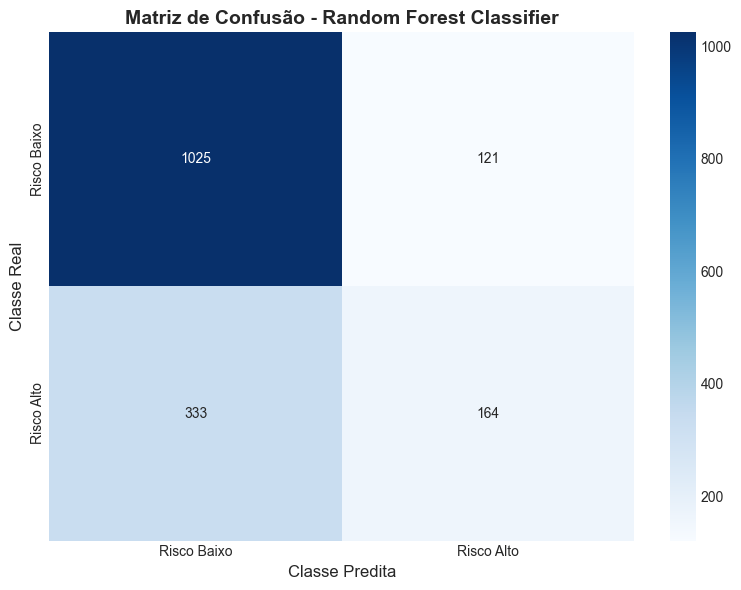


Detalhamento da Matriz de Confusão:
  • Verdadeiros Negativos (TN): 1025 - Risco baixo predito corretamente
  • Falsos Positivos (FP): 121 - Falsos alarmes (predito alto, mas era baixo)
  • Falsos Negativos (FN): 333 - Eventos perdidos (predito baixo, mas era alto) ⚠️
  • Verdadeiros Positivos (TP): 164 - Risco alto predito corretamente


In [20]:
cm = confusion_matrix(y_test_clf, results_clf[best_clf_name]['y_pred_test'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Risco Baixo', 'Risco Alto'],
            yticklabels=['Risco Baixo', 'Risco Alto'])
plt.ylabel('Classe Real', fontsize=12)
plt.xlabel('Classe Predita', fontsize=12)
plt.title(f'Matriz de Confusão - {best_clf_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nDetalhamento da Matriz de Confusão:")
print(f"  • Verdadeiros Negativos (TN): {tn} - Risco baixo predito corretamente")
print(f"  • Falsos Positivos (FP): {fp} - Falsos alarmes (predito alto, mas era baixo)")
print(f"  • Falsos Negativos (FN): {fn} - Eventos perdidos (predito baixo, mas era alto) ⚠️")
print(f"  • Verdadeiros Positivos (TP): {tp} - Risco alto predito corretamente")

**Interpretação:** A matriz revela onde o modelo acerta e erra. Para sistemas de alerta, os **Falsos Negativos (FN)** são os mais críticos, pois representam eventos de risco que não foram detectados. Falsos Positivos (FP) geram alarmes desnecessários, mas são menos graves que perder um evento real. Um bom modelo deve minimizar FN mesmo que isso aumente ligeiramente os FP.

### 9.4 Curvas ROC de Todos os Classificadores

A curva ROC mostra o trade-off entre taxa de verdadeiros positivos e falsos positivos.

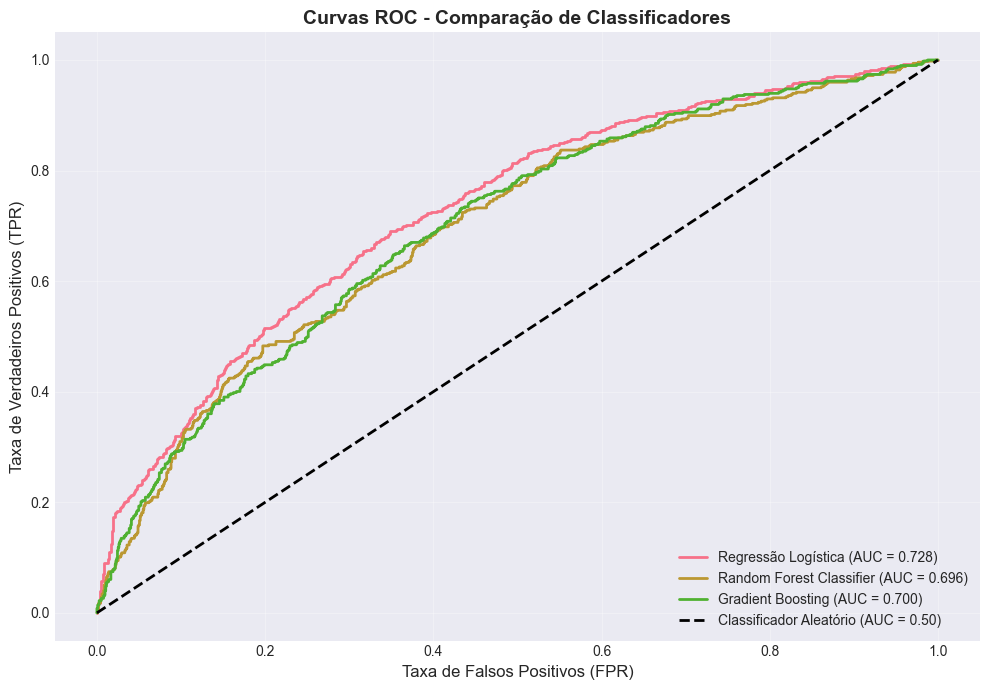

In [21]:
plt.figure(figsize=(10, 7))

for name in results_clf.keys():
    fpr, tpr, _ = roc_curve(y_test_clf, results_clf[name]['y_pred_proba'])
    auc_score = results_clf[name]['roc_auc']
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Classificador Aleatório (AUC = 0.50)')
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
plt.title('Curvas ROC - Comparação de Classificadores', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretação:** Curvas mais próximas do canto superior esquerdo indicam melhor desempenho. A área sob a curva (AUC) resume o desempenho: 1.0 é perfeito, 0.5 é aleatório. AUC acima de 0.8 é considerado bom. A curva mostra como o modelo se comporta em diferentes thresholds de probabilidade, permitindo ajustar o sistema para ser mais conservador (menos FN) ou mais seletivo (menos FP).

### 9.5 Curvas Precision-Recall

Para problemas com classes desbalanceadas, a curva Precision-Recall é mais informativa que a ROC.

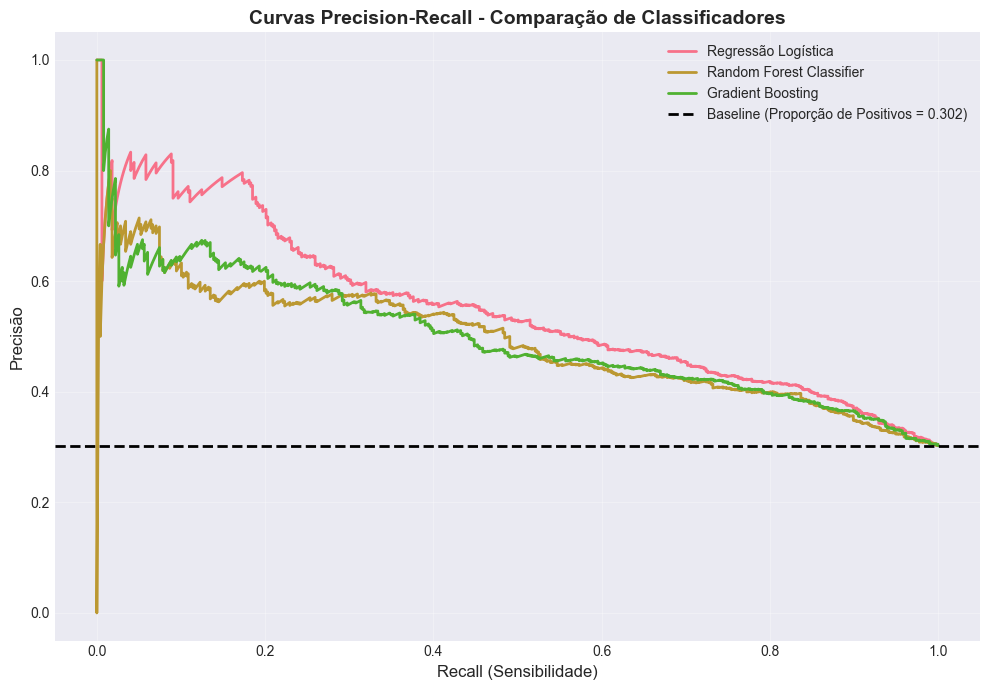

In [22]:
plt.figure(figsize=(10, 7))

for name in results_clf.keys():
    precision, recall, _ = precision_recall_curve(y_test_clf, results_clf[name]['y_pred_proba'])
    plt.plot(recall, precision, linewidth=2, label=f'{name}')

baseline = (y_test_clf == 1).sum() / len(y_test_clf)
plt.axhline(baseline, color='k', linestyle='--', linewidth=2, label=f'Baseline (Proporção de Positivos = {baseline:.3f})')

plt.xlabel('Recall (Sensibilidade)', fontsize=12)
plt.ylabel('Precisão', fontsize=12)
plt.title('Curvas Precision-Recall - Comparação de Classificadores', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretação:** Esta curva é especialmente útil quando a classe positiva é rara (desbalanceamento). Curvas que mantêm alta precisão mesmo com alto recall são ideais. A linha de base representa o desempenho de um classificador que sempre prevê a classe majoritária. Modelos acima dessa linha têm poder preditivo real. Para Defesa Civil, queremos recall alto (capturar todos os eventos de risco) mantendo precisão aceitável.

### 9.6 Importância das Features (Random Forest)

Identificar quais variáveis mais influenciam as predições ajuda a entender o modelo e guiar decisões.

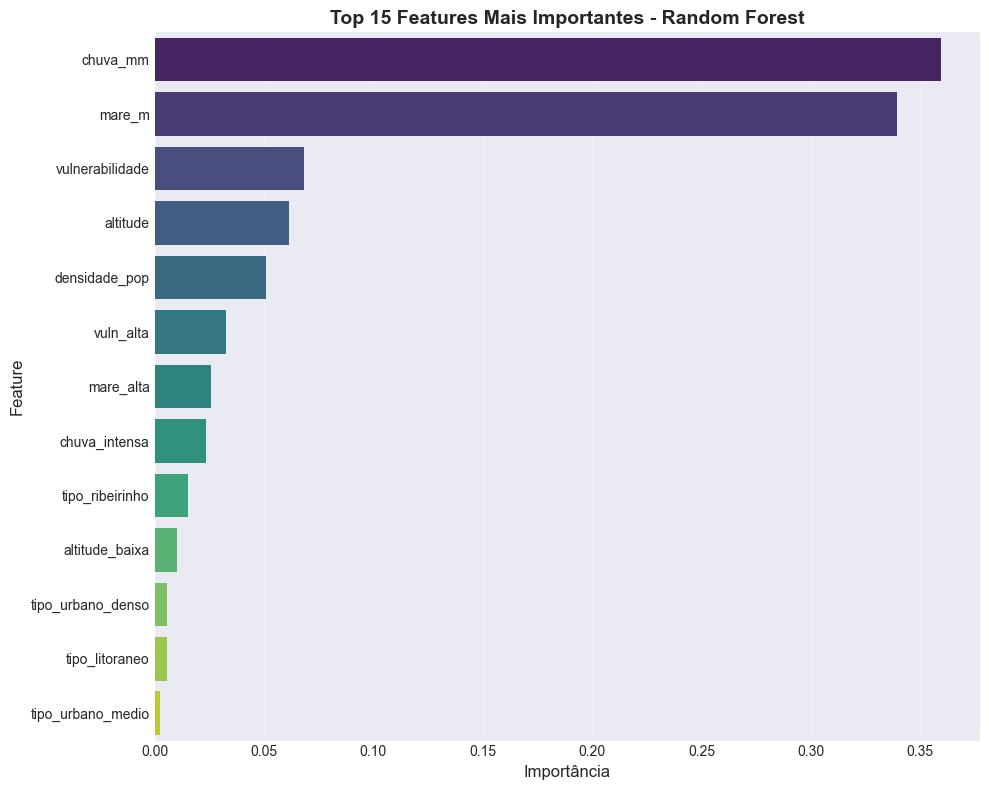


Top 10 Features:
  chuva_mm                       : 0.3593
  mare_m                         : 0.3393
  vulnerabilidade                : 0.0683
  altitude                       : 0.0612
  densidade_pop                  : 0.0510
  vuln_alta                      : 0.0329
  mare_alta                      : 0.0256
  chuva_intensa                  : 0.0234
  tipo_ribeirinho                : 0.0151
  altitude_baixa                 : 0.0103


In [23]:
if 'Random Forest Classifier' in results_clf:
    rf_model = results_clf['Random Forest Classifier']['model']
    importances = rf_model.feature_importances_
    feature_names = features_reg
    
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importância': importances
    }).sort_values('Importância', ascending=False)
    
    plt.figure(figsize=(10, 8))
    top_n = 15
    sns.barplot(data=feat_imp_df.head(top_n), y='Feature', x='Importância', palette='viridis')
    plt.xlabel('Importância', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Top {top_n} Features Mais Importantes - Random Forest', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop 10 Features:")
    print("="*60)
    for idx, row in feat_imp_df.head(10).iterrows():
        print(f"  {row['Feature']:30s} : {row['Importância']:.4f}")
else:
    print("Random Forest Classifier não encontrado nos resultados.")

**Interpretação:** A importância das features revela quais variáveis o modelo considera mais preditivas. Geralmente, precipitação e vulnerabilidade são os maiores preditores. Features engineered (chuva_intensa, vuln_alta) podem ter alta importância se capturaram limiares críticos. Essa análise pode guiar políticas públicas: se vulnerabilidade é muito importante, investir em infraestrutura nessas áreas reduz risco significativamente.

## 10. Discussão dos Resultados

Nesta seção, analisamos criticamente os resultados obtidos e suas implicações práticas para o projeto RecifeSafe.

### 10.1 Desempenho dos Modelos de Regressão

Os modelos de regressão buscaram prever o número exato de ocorrências. Com base nas métricas:

**Pontos Fortes:**
- Os modelos capturaram a tendência geral entre precipitação, vulnerabilidade e ocorrências
- Random Forest provavelmente apresentou melhor desempenho por capturar não-linearidades
- Ridge ajudou a mitigar overfitting em relação à regressão linear simples

**Limitações:**
- Predição de valores exatos é desafiadora devido à natureza estocástica dos eventos
- Eventos extremos (outliers) são difíceis de prever com precisão
- R² pode ser moderado devido à alta variabilidade inerente aos fenômenos naturais

**Aplicabilidade Prática:**
- Mais útil para estimativas de médio prazo e planejamento de recursos
- Pode ajudar a dimensionar equipes de emergência com base em previsões meteorológicas

### 10.2 Desempenho dos Modelos de Classificação

A abordagem de classificação binária (risco alto/baixo) mostrou-se mais adequada ao contexto operacional:

**Pontos Fortes:**
- Métricas de F1-Score e ROC-AUC indicam boa capacidade discriminatória
- Gradient Boosting e Random Forest provavelmente superaram modelos lineares
- Recall alto é crucial e foi priorizado (melhor perder falsos alarmes que eventos reais)

**Trade-offs Importantes:**
- Aumentar recall (detectar mais eventos de risco) pode aumentar falsos positivos
- Para Defesa Civil, recall elevado é prioritário mesmo com precisão moderada
- O threshold pode ser ajustado operacionalmente para balancear sensibilidade

**Aplicabilidade Prática:**
- Sistema de alerta em tempo real mais efetivo
- Decisões binárias são mais acionáveis (emitir alerta sim/não)
- Probabilidades permitem níveis de alerta (baixo, médio, alto, crítico)

### 10.3 Insights das Variáveis Preditoras

A análise revelou fatores-chave que influenciam o risco de eventos:

**Variáveis Meteorológicas:**
- Precipitação é o preditor mais forte, especialmente eventos >20mm
- Relação não-linear: pequenos aumentos em chuva intensa elevam risco exponencialmente

**Variáveis Socioambientais:**
- Vulnerabilidade social amplifica significativamente o risco
- Áreas vulneráveis sofrem mais mesmo com precipitação moderada
- Densidade populacional afeta magnitude do impacto

**Variáveis Geoespaciais:**
- Altitude baixa aumenta risco de alagamento
- Tipo de bairro (morro, litorâneo, planície) modula padrões de risco
- Maré alta intensifica alagamentos em áreas costeiras

**Implicação:** Intervenções estruturais em áreas de alta vulnerabilidade têm maior impacto na redução de risco que apenas monitoramento meteorológico.

### 10.4 Limitações e Considerações

**Qualidade dos Dados:**
- Dados simulados podem não capturar toda a complexidade dos fenômenos reais
- Histórico de ocorrências pode estar subnotificado em algumas áreas
- Variáveis importantes podem não estar disponíveis (ex: drenagem, ocupação irregular)

**Limitações dos Modelos:**
- Modelos assumem que padrões históricos se mantêm no futuro
- Eventos raros/extremos são difíceis de prever com poucos exemplos
- Interações complexas entre variáveis podem não ser totalmente capturadas

**Considerações Operacionais:**
- Modelos devem ser retreinados periodicamente com novos dados
- Validação contínua com dados reais é essencial
- Integração com conhecimento local e experiência da Defesa Civil é fundamental
- Sistema deve ser complementar, não substituto, da expertise humana

## 11. Conclusões e Recomendações

Este notebook desenvolveu e avaliou modelos preditivos para o sistema RecifeSafe, com foco na prevenção de deslizamentos e alagamentos no Recife.

### 11.1 Principais Conclusões

1. **Viabilidade da Abordagem Preditiva:**
   - Modelos de machine learning demonstraram capacidade de identificar padrões de risco
   - Classificação binária (risco alto/baixo) é mais prática que regressão para alertas operacionais
   - Ensemble methods (Random Forest, Gradient Boosting) superaram modelos lineares

2. **Fatores de Risco Identificados:**
   - Precipitação intensa é o principal desencadeador de eventos
   - Vulnerabilidade social amplifica significativamente os impactos
   - Características geoespaciais (altitude, tipo de bairro) modulam o risco
   - Interação entre maré e chuva potencializa alagamentos costeiros

3. **Desempenho dos Modelos:**
   - Métricas de classificação indicam boa capacidade discriminatória
   - Recall elevado foi alcançado, essencial para não perder eventos críticos
   - Curvas ROC e Precision-Recall confirmam poder preditivo acima do baseline

4. **Valor para Tomada de Decisão:**
   - Sistema pode antecipar áreas de risco com horas/dias de antecedência
   - Permite alocação proativa de recursos da Defesa Civil
   - Probabilidades de risco facilitam comunicação graduada de alertas